In [2]:
import pandas as pd
import pybaseball as pyb
from pybaseball import statcast
from datetime import datetime

# Define the start and end dates for the seasons you're interested in
start_date_2022 = '2022-04-07'
end_date_2022 = '2022-10-05'

start_date_2023 = '2023-04-01'
end_date_2023 = '2023-10-01'

start_date_2024 = '2024-04-01'  # Placeholder; update based on the start of the season
end_date_2024 = '2024-10-01'    # Placeholder; update based on the end of the season

# Pull data for each season using pybaseball
data_2022 = statcast(start_date_2022, end_date_2022)
data_2023 = statcast(start_date_2023, end_date_2023)
data_2024 = statcast(start_date_2024, end_date_2024)


This is a large query, it may take a moment to complete


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pybaseball/statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)
  0%|          | 0/182 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passin

This is a large query, it may take a moment to complete


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pybaseball/statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)
  0%|          | 0/184 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passin

This is a large query, it may take a moment to complete


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pybaseball/statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)
  0%|          | 0/184 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passin

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
import joblib
from datetime import datetime

mlbraw = pd.concat([data_2022, data_2023, data_2024])

# Clean up the data (remove duplicates, filter for RHP vs LHB)
mlbraw = mlbraw.drop_duplicates()


# Filter out pitchers who are hitting
pitchers = mlbraw.groupby('pitcher').size().reset_index(name='pitches')
pitchers = pitchers.query('pitches > 74 and pitcher != "660271"')
mlbraw1 = mlbraw[~mlbraw['batter'].isin(pitchers['pitcher'])]

# Additional filters and transformations
mlbraw1 = mlbraw1[
    (mlbraw1['description'] != "pitchout") & 
    (mlbraw1['balls'] < 4) & 
    (mlbraw1['strikes'] < 3) & 
    (mlbraw1['outs_when_up'] < 3) &
    mlbraw1[['release_speed', 'release_spin_rate', 'release_extension', 
             'release_pos_x', 'release_pos_z', 'p_throws', 'stand', 'zone', 
             'plate_x', 'plate_z', 'spin_axis', 'pfx_x', 'pfx_z', 'delta_run_exp']].notna().all(axis=1)
]

# Additional transformations (e.g., flipping x for left-handed pitchers, categorizing events)
mlbraw1['release_pos_x'] = mlbraw1['release_pos_x'].where(mlbraw1['p_throws'] == 'R', -mlbraw1['release_pos_x'])
mlbraw1['pfx_x'] = mlbraw1['pfx_x'].where(mlbraw1['p_throws'] == 'R', -mlbraw1['pfx_x'])
mlbraw1['spin_axis'] = mlbraw1['spin_axis'].where(mlbraw1['p_throws'] == 'R', -mlbraw1['spin_axis'])
mlbraw1['out_of_zone'] = (mlbraw1['zone'] > 9).astype(int)
mlbraw1['year'] = pd.to_datetime(mlbraw1['game_date']).dt.year

# Adjust event types (similar to how it was done in R)
event_map = {
    "double_play": "out", "triple_play": "out", "field_error": "out", 
    "field_out": "out", "fielders_choice": "out", "fielders_choice_out": "out", 
    "force_out": "out", "grounded_into_double_play": "out", "sac_fly": "sacrifice", 
    "sac_bunt": "sacrifice", "sac_fly_double_play": "sacrifice", "sac_bunt_double_play": "sacrifice"
}
mlbraw1['events'] = mlbraw1['events'].map(event_map).fillna(mlbraw1['events'])

# Adjust pitch types
mlbraw1['pitch_type'] = mlbraw1['pitch_type'].replace({
    "FT": "SI", "SI": "SI", "CU": "CU", "KC": "CU", "ST": "SL", "SL": "SL", "SV": "SL"
})

# Calculate the delta run values for ball and strike events
bs_vals = mlbraw1[mlbraw1['type'] != "X"].groupby('type')['delta_run_exp'].mean().reset_index(name='dre_bs')

# Calculate delta run for balls in play (X)
ip_filt = mlbraw1[mlbraw1['type'] == 'X']
event_lm = ip_filt.groupby('events')['delta_run_exp'].mean().reset_index(name='dre_ip')

# Merge calculated values into the main dataframe
mlbraw1 = mlbraw1.merge(bs_vals, on="type", how="left")
mlbraw1 = mlbraw1.merge(event_lm, on="events", how="left")
mlbraw1['dre_final'] = mlbraw1['dre_bs'].where(mlbraw1['type'] != "X", mlbraw1['dre_ip'])

# Filter pitcher fastball metrics
pitcher_fastballs = mlbraw1[mlbraw1['pitch_type'].isin(['FF', 'FC', 'SI'])]
pitcher_fastballs = pitcher_fastballs.groupby(['pitcher', 'year']).agg({
    'release_speed': 'mean', 'pfx_z': lambda x: x.quantile(0.8), 
    'pfx_x': lambda x: x.quantile(0.8), 'release_speed': lambda x: x.quantile(0.8), 
    'spin_axis': 'mean'
}).reset_index()

# Merge fastball metrics into mlbraw2 (assuming pitcher_fastballs has spin_axis_y)
mlbraw2 = mlbraw1.merge(pitcher_fastballs, on=['pitcher', 'year'], how='left')

# Handle 'spin_axis_x' instead of 'spin_axis' in mlbraw2
if 'spin_axis_x' in mlbraw2.columns:
    mlbraw2['spin_axis'] = mlbraw2['spin_axis_x']  # Use 'spin_axis_x' from the merged DataFrame
else:
    mlbraw2['spin_axis'] = 0  # Or handle the case where 'spin_axis_x' is missing

# Create feature differences using the correct 'spin_axis_x'
mlbraw2['spin_dif'] = mlbraw2['spin_axis'] - mlbraw2['spin_axis']  # Make sure to use the merged 'spin_axis'
mlbraw2['velo_dif'] = mlbraw2['release_speed_x'] - mlbraw2['release_speed_y']  # Adjust with 'release_speed' columns
mlbraw2['ivb_dif'] = mlbraw2['pfx_z_x'] - mlbraw2['pfx_z_y']  # Adjust with pfx columns
mlbraw2['break_dif'] = (mlbraw2['pfx_x_x'] * 0.5 + mlbraw2['pfx_x_y'] * 0.5) - mlbraw2['pfx_x_y']

# Select variables for model
final_vars = mlbraw2[['dre_final', 'release_speed_x', 'release_spin_rate', 'release_extension', 
                      'release_pos_x', 'release_pos_z', 'pfx_x_x', 'pfx_z_x', 'spin_axis', 'spin_dif', 
                      'velo_dif', 'ivb_dif', 'break_dif']]
final_vars = final_vars.join(mlbraw2[['pitch_type']], how='left')

print(final_vars.columns.tolist())


# One-hot encode pitch_type
# One-hot encode pitch_type
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)  # Corrected keyword argument
pitch_type_encoded = encoder.fit_transform(final_vars[['pitch_type']])
pitch_type_df = pd.DataFrame(pitch_type_encoded, columns=encoder.get_feature_names_out(['pitch_type']))

# Combine the encoded data
final_vars = final_vars.drop(columns=['pitch_type']).join(pitch_type_df)


# Split data into train and test
from sklearn.model_selection import train_test_split
X = final_vars.drop(columns='dre_final')
y = final_vars['dre_final']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4813)

# XGBoost model setup
import xgboost as xgb
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", eval_metric="rmse", random_state=4813)

# Hyperparameter tuning with RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    'max_depth': range(3, 15),
    'min_child_weight': range(3, 11),
    'subsample': [i/10 for i in range(3, 11)],
    'colsample_bytree': [i/10 for i in range(3, 11)],
    'gamma': range(0, 6),
    'alpha': range(0, 6),
    'n_estimators': [50, 100, 200, 300, 400],
    'learning_rate': [0.01, 0.03, 0.05, 0.075, 0.1]
}
random_search = RandomizedSearchCV(xgb_model, param_grid, n_iter=10, scoring='neg_root_mean_squared_error', cv=5, verbose=1)
random_search.fit(X_train, y_train)

# Train the best model
best_model = random_search.best_estimator_

# Make predictions and evaluate
y_pred = best_model.predict(X_test)

# Calculate MSE (Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)

# Manually calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)
# Save the model
import joblib
joblib.dump(best_model, "jl_stuff.pkl")

print(f"RMSE: {rmse}")


['dre_final', 'release_speed_x', 'release_spin_rate', 'release_extension', 'release_pos_x', 'release_pos_z', 'pfx_x_x', 'pfx_z_x', 'spin_axis', 'spin_dif', 'velo_dif', 'ivb_dif', 'break_dif', 'pitch_type']
Fitting 5 folds for each of 10 candidates, totalling 50 fits
RMSE: 0.20160286299639535


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
import joblib
from datetime import datetime

# Combine data from multiple years (2022, 2023, 2024)
mlbraw = pd.concat([data_2022, data_2023, data_2024])

# Clean up the data (remove duplicates, filter for RHP vs LHB)
mlbraw = mlbraw.drop_duplicates()

# Filter out pitchers who are hitting
pitchers = mlbraw.groupby('pitcher').size().reset_index(name='pitches')
pitchers = pitchers.query('pitches > 74 and pitcher != "660271"')
mlbraw1 = mlbraw[~mlbraw['batter'].isin(pitchers['pitcher'])]

# Additional filters and transformations
mlbraw1 = mlbraw1[
    (mlbraw1['description'] != "pitchout") & 
    (mlbraw1['balls'] < 4) & 
    (mlbraw1['strikes'] < 3) & 
    (mlbraw1['outs_when_up'] < 3) &
    mlbraw1[['release_speed', 'release_spin_rate', 'release_extension', 
             'release_pos_x', 'release_pos_z', 'p_throws', 'stand', 'zone', 
             'plate_x', 'plate_z', 'spin_axis', 'pfx_x', 'pfx_z', 'delta_run_exp']].notna().all(axis=1)
]

# Additional transformations (e.g., flipping x for left-handed pitchers, categorizing events)
mlbraw1['release_pos_x'] = mlbraw1['release_pos_x'].where(mlbraw1['p_throws'] == 'R', -mlbraw1['release_pos_x'])
mlbraw1['pfx_x'] = mlbraw1['pfx_x'].where(mlbraw1['p_throws'] == 'R', -mlbraw1['pfx_x'])
mlbraw1['spin_axis'] = mlbraw1['spin_axis'].where(mlbraw1['p_throws'] == 'R', -mlbraw1['spin_axis'])
mlbraw1['out_of_zone'] = (mlbraw1['zone'] > 9).astype(int)
mlbraw1['year'] = pd.to_datetime(mlbraw1['game_date']).dt.year

# Adjust event types (similar to how it was done in R)
event_map = {
    "double_play": "out", "triple_play": "out", "field_error": "out", 
    "field_out": "out", "fielders_choice": "out", "fielders_choice_out": "out", 
    "force_out": "out", "grounded_into_double_play": "out", "sac_fly": "sacrifice", 
    "sac_bunt": "sacrifice", "sac_fly_double_play": "sacrifice", "sac_bunt_double_play": "sacrifice"
}
mlbraw1['events'] = mlbraw1['events'].map(event_map).fillna(mlbraw1['events'])

# Adjust pitch types
mlbraw1['pitch_type'] = mlbraw1['pitch_type'].replace({
    "FT": "SI", "SI": "SI", "CU": "CU", "KC": "CU", "ST": "SL", "SL": "SL", "SV": "SL"
})

# Calculate the delta run values for ball and strike events
bs_vals = mlbraw1[mlbraw1['type'] != "X"].groupby('type')['delta_run_exp'].mean().reset_index(name='dre_bs')

# Calculate delta run for balls in play (X)
ip_filt = mlbraw1[mlbraw1['type'] == 'X']
event_lm = ip_filt.groupby('events')['delta_run_exp'].mean().reset_index(name='dre_ip')

# Merge calculated values into the main dataframe
mlbraw1 = mlbraw1.merge(bs_vals, on="type", how="left")
mlbraw1 = mlbraw1.merge(event_lm, on="events", how="left")
mlbraw1['dre_final'] = mlbraw1['dre_bs'].where(mlbraw1['type'] != "X", mlbraw1['dre_ip'])

# Now apply standardization to the numerical features
features_to_standardize = ['release_speed', 'release_spin_rate', 'release_extension', 
                           'release_pos_x', 'release_pos_z', 'spin_axis', 'pfx_x', 'pfx_z', 
                           'dre_final']  # Include dre_final if you plan to standardize it

scaler = StandardScaler()
mlbraw1[features_to_standardize] = scaler.fit_transform(mlbraw1[features_to_standardize])

# Select variables for model
final_vars = mlbraw1[['dre_final', 'release_speed', 'release_spin_rate', 'release_extension', 
                      'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z', 'spin_axis']]
final_vars = final_vars.join(mlbraw1[['pitch_type']], how='left')

# One-hot encode pitch_type
encoder = OneHotEncoder(sparse_output=False)
pitch_type_encoded = encoder.fit_transform(final_vars[['pitch_type']])
pitch_type_df = pd.DataFrame(pitch_type_encoded, columns=encoder.get_feature_names_out(['pitch_type']))

# Combine the encoded data
final_vars = final_vars.drop(columns=['pitch_type']).join(pitch_type_df)

# Split data into train and test
X = final_vars.drop(columns='dre_final')
y = final_vars['dre_final']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4813)

# XGBoost model setup
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", eval_metric="rmse", random_state=4813)

# Hyperparameter tuning with RandomizedSearchCV
param_grid = {
    'max_depth': range(3, 15),
    'min_child_weight': range(3, 11),
    'subsample': [i/10 for i in range(3, 11)],
    'colsample_bytree': [i/10 for i in range(3, 11)],
    'gamma': range(0, 6),
    'alpha': range(0, 6),
    'n_estimators': [50, 100, 200, 300, 400],
    'learning_rate': [0.01, 0.03, 0.05, 0.075, 0.1]
}
random_search = RandomizedSearchCV(xgb_model, param_grid, n_iter=10, scoring='neg_root_mean_squared_error', cv=5, verbose=1)
random_search.fit(X_train, y_train)

# Train the best model
best_model = random_search.best_estimator_

# Make predictions and evaluate
y_pred = best_model.predict(X_test)

# Calculate MSE (Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)

# Manually calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)

# Save the model
joblib.dump(best_model, "jl_stuff.pkl")

print(f"RMSE: {rmse}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
RMSE: 0.9975688207810888


In [5]:
# Step 1: Calculate the league average and standard deviation of predicted values (dre_final)
mean_pred = mlbraw1['dre_final'].mean()  # Mean of dre_final values
std_pred = mlbraw1['dre_final'].std()  # Standard deviation of dre_final values

# Step 2: Transform predictions into Stuff+ scores
mlbraw1['stuff_plus'] = 100 + 10 * ((mlbraw1['dre_final'] - mean_pred) / std_pred)

# Step 3: Now you have Stuff+ values scaled to have a mean of 100 and a standard deviation of 10
# Make sure to check the output:
print("Stuff+ by Pitcher:")
pitcher_stuff_plus = mlbraw1.groupby('pitcher')['stuff_plus'].mean().reset_index()
print(pitcher_stuff_plus)

print("\nStuff+ by Pitch Type:")
pitch_type_stuff_plus = mlbraw1.groupby('pitch_type')['stuff_plus'].mean().reset_index()
print(pitch_type_stuff_plus)


Stuff+ by Pitcher:
      pitcher  stuff_plus
0      405395  102.335115
1      424144  101.190608
2      425794  100.271784
3      425844  100.199772
4      425877  104.684335
...       ...         ...
1323   800049  100.764830
1324   805673  100.861495
1325   806185  100.119965
1326   808967   99.746029
1327   814005  101.049169

[1328 rows x 2 columns]

Stuff+ by Pitch Type:
   pitch_type  stuff_plus
0          CH  100.161850
1          CS  100.666142
2          CU  100.088747
3          EP  101.740675
4          FA  101.908091
5          FC   99.998534
6          FF   99.971478
7          FO  100.281730
8          FS  100.014881
9          KN  100.708761
10         SC  101.087820
11         SI   99.911386
12         SL   99.967048


In [9]:
import pybaseball as pyb
print(pyb.playerid_lookup('Smith','Cade'))

Gathering player lookup table. This may take a moment.
  name_last name_first  key_mlbam key_retro  key_bbref  key_fangraphs  \
0     smith       cade     671922  smitc009  smithca06          27867   

   mlb_played_first  mlb_played_last  
0            2024.0           2024.0  


Stuff+ by Pitch Type for Pitcher ID 671922:
  pitch_type  stuff_plus
0         FF   98.903006
1         FS   99.850887
2         SL  101.293846


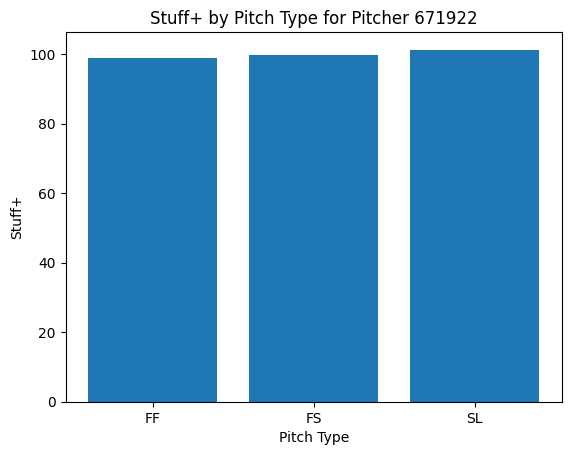

In [10]:
# Example pitcher_id you want to inspect
pitcher_id_of_interest = 671922  # Replace with the pitcher_id you're interested in

# Filter the data for the specific pitcher
pitcher_data = mlbraw1[mlbraw1['pitcher'] == pitcher_id_of_interest]

# View Stuff+ values for each pitch by pitch type for that pitcher
pitcher_pitch_type_stuff = pitcher_data.groupby('pitch_type')['stuff_plus'].mean().reset_index()

# Optionally, you can print or visualize the Stuff+ values
print(f"Stuff+ by Pitch Type for Pitcher ID {pitcher_id_of_interest}:")
print(pitcher_pitch_type_stuff)

# Visualize Stuff+ by Pitch Type
import matplotlib.pyplot as plt

plt.bar(pitcher_pitch_type_stuff['pitch_type'], pitcher_pitch_type_stuff['stuff_plus'])
plt.xlabel('Pitch Type')
plt.ylabel('Stuff+')
plt.title(f'Stuff+ by Pitch Type for Pitcher {pitcher_id_of_interest}')
plt.show()


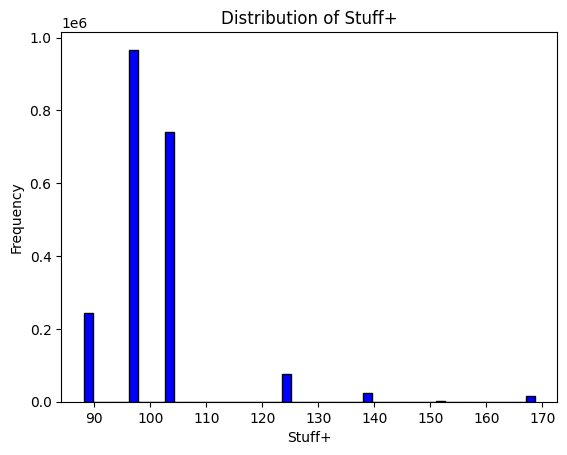

In [41]:
import matplotlib.pyplot as plt

# Plot distribution of Stuff+ values
plt.hist(mlbraw1['stuff_plus'], bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Stuff+')
plt.xlabel('Stuff+')
plt.ylabel('Frequency')
plt.show()


/var/folders/pn/s56mk9md5zzd_jwqqhtnf7fr0000gn/T/ipykernel_1646/3367501909.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=mlbraw1[mlbraw1['pitch_type'] == pitch_type]['stuff_plus'],
/var/folders/pn/s56mk9md5zzd_jwqqhtnf7fr0000gn/T/ipykernel_1646/3367501909.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=mlbraw1[mlbraw1['pitch_type'] == pitch_type]['stuff_plus'],
/var/folders/pn/s56mk9md5zzd_jwqqhtnf7fr0000gn/T/ipykernel_1646/3367501909.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=mlbraw1[mlbraw1['pitch_type'] == pitch_type]['stuff_plus'],
/var/folders/pn/s56mk9md5zzd_jwqqhtnf7fr0000gn/T/

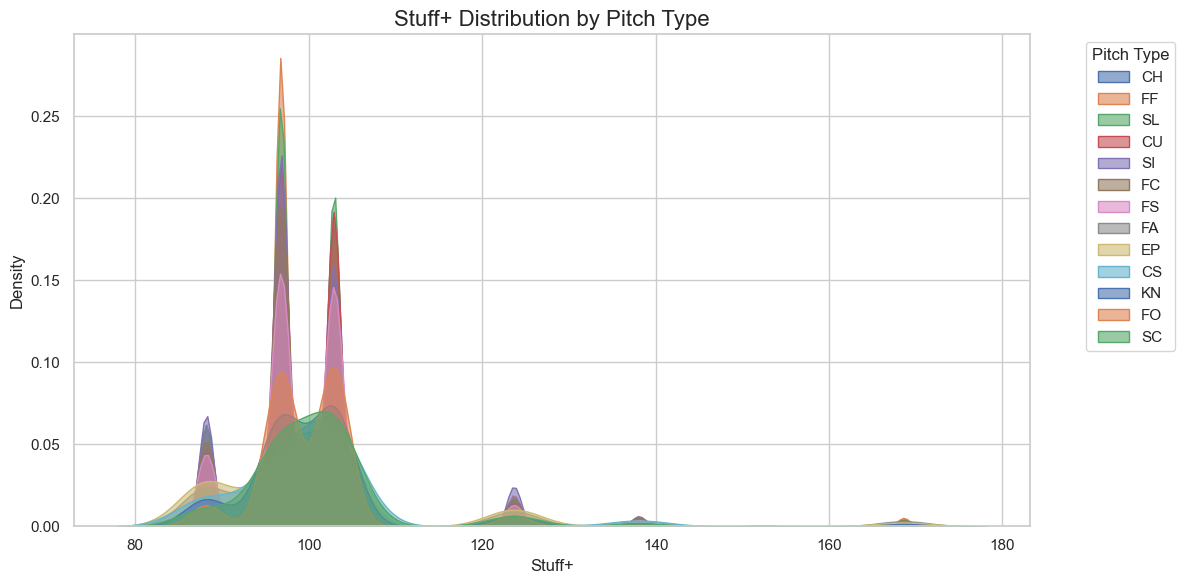

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plot with seaborn style
sns.set(style="whitegrid")

# Create a density plot for Stuff+ by pitch type
plt.figure(figsize=(12, 6))

# Loop through each pitch type and plot its distribution
for pitch_type in mlbraw1['pitch_type'].unique():
    sns.kdeplot(data=mlbraw1[mlbraw1['pitch_type'] == pitch_type]['stuff_plus'], 
                label=pitch_type, 
                shade=True, 
                alpha=0.6)  # alpha for transparency

# Customize plot
plt.title('Stuff+ Distribution by Pitch Type', fontsize=16)
plt.xlabel('Stuff+', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title="Pitch Type", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()


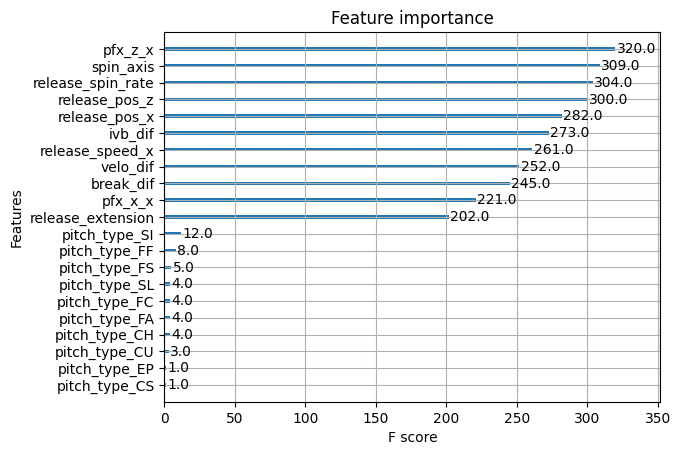

In [21]:
# Plot feature importance
xgb.plot_importance(best_model)
plt.show()


In [31]:
# Make predictions for the test set (or full dataset if you prefer)
y_pred = best_model.predict(X_test)  # Predicting delta run values

# Calculate the league average and standard deviation from all predictions
league_average = y_pred.mean()
league_std = y_pred.std()

# Calculate Stuff+ for each prediction
stuff_plus = 100 + 10 * ((y_pred - league_average) / league_std)

# Combine Stuff+ with pitch data (optional)
result_df = X_test.copy()  # Assuming X_test contains the original pitch data
result_df['Stuff+'] = stuff_plus


print(result_df.columns.tolist())

# Display the first few rows of result_df with Stuff+ and relevant features
print(result_df[['Stuff+', 'release_speed_x', 'release_spin_rate', 'pfx_x_x', 'pfx_z_x', 'spin_axis', 
                 'spin_dif', 'velo_dif', 'ivb_dif', 'break_dif', 'pitch_type_FA']].head())



['release_speed_x', 'release_spin_rate', 'release_extension', 'release_pos_x', 'release_pos_z', 'pfx_x_x', 'pfx_z_x', 'spin_axis', 'spin_dif', 'velo_dif', 'ivb_dif', 'break_dif', 'pitch_type_CH', 'pitch_type_CS', 'pitch_type_CU', 'pitch_type_EP', 'pitch_type_FA', 'pitch_type_FC', 'pitch_type_FF', 'pitch_type_FO', 'pitch_type_FS', 'pitch_type_KN', 'pitch_type_SC', 'pitch_type_SI', 'pitch_type_SL', 'pitch_type_nan', 'Stuff+']
            Stuff+  release_speed_x  release_spin_rate  pfx_x_x  pfx_z_x  \
263350  100.709785             93.3               2336    -0.63      1.4   
78764    95.687943             84.6               2405     1.04     -0.1   
456034  105.273354             82.6               2116     0.56    -0.51   
438507   93.085091             89.6                743    -0.45    -0.27   
176837  101.892113             94.4               2438    -0.87     1.42   

        spin_axis  spin_dif  velo_dif  ivb_dif  break_dif  pitch_type_FA  
263350        211         0      -0.7   